# **Importando las librerías**

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.6 MB/s eta 0:00:00


In [ ]:
#herramientas
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import string
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.pipeline import Pipeline
import contractions

#métricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import time

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

sns.set_theme(style="whitegrid")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
df = pd.read_csv("/gdrive/MyDrive/IA-PROYECTO-2023-1/cyberbullying_tweets.csv")

# **Primer vistazo a los datos**

In [ ]:
df.shape

(47692, 2)

In [ ]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


# **Conversión a un tipo apropiado de datos**

In [ ]:
df[df.columns] = df[df.columns].astype('string')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  string
 1   cyberbullying_type  47692 non-null  string
dtypes: string(2)
memory usage: 745.3 KB


# **Búsqueda de valores nulos**

In [ ]:
df.isna().any()

tweet_text            False
cyberbullying_type    False
dtype: bool

In [ ]:
df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

# **Valores únicos del dataset**

In [ ]:
df.nunique()

tweet_text            46017
cyberbullying_type        6
dtype: int64

# **Distribución de las clases**

In [ ]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: Int64

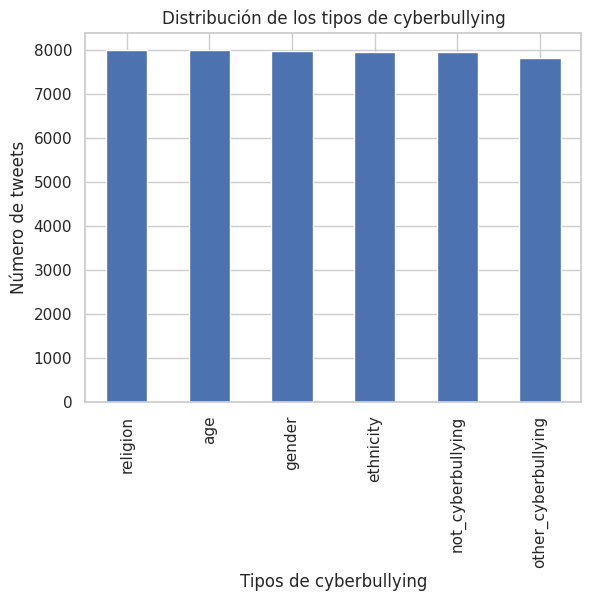

In [ ]:
class_counts = df['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribución de los tipos de cyberbullying')
plt.xlabel('Tipos de cyberbullying')
plt.ylabel('Número de tweets')
plt.show()

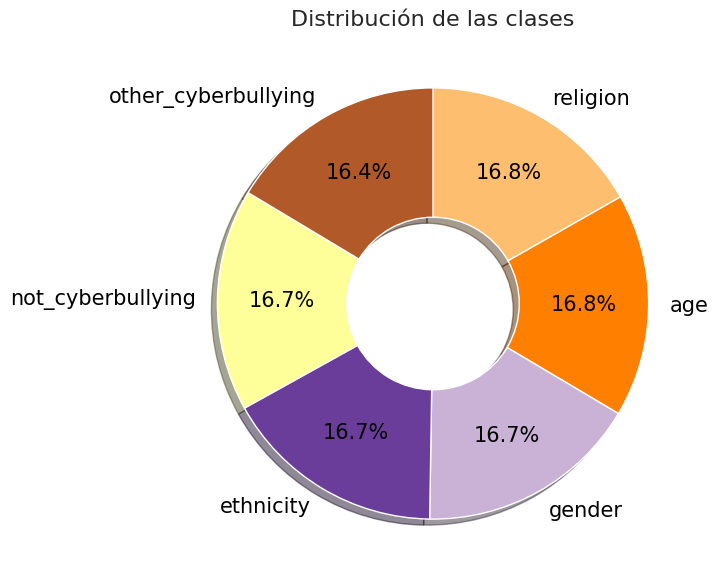

In [ ]:
plt.figure(figsize = (7,7))
sorted_counts = df['cyberbullying_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[6:])
plt.title('Distribución de las clases', fontsize = 16);

# **Limpieza de tweets**

In [ ]:
def tweets_cleaner(tweet):
    # remover las URLs
    tweet = re.sub(r'((www.\S+)|(https?://\S+))', r'', tweet)
    # remover números
    tweet = re.sub(r'[0-9]\S+', r'', tweet)
    # remover etiquetas
    tweet = re.sub(r'(@\S+) | (#\S+)', r'', tweet)
    # remover puntuación
    tweet = [char for char in tweet if char not   
                                in string.punctuation]
    # convertir a string
    tweet = "".join(tweet)
    # quitar contracciones
    tweet = contractions.fix(tweet)
    # quitar dobles espacios
    tweet = re.sub("\s\s+" , " ", tweet)
    # conjunto de stopwords
    stop_words = set(stopwords.words("english"))
    # remover las stopwords 
    tweet = [w for w in tweet.split()
                              if w.lower() not in stop_words]
    return tweet

# **Extracción de features**

In [ ]:
%%time

tqdm.pandas()

# extraer las features
vectorizer = CountVectorizer(analyzer = tweets_cleaner, dtype =     
                            'uint8')
X_cv = vectorizer.fit_transform(df['tweet_text'])

CPU times: user 16.1 s, sys: 1.15 s, total: 17.2 s
Wall time: 24.9 s


In [ ]:
X_cv.shape

(47692, 60530)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [ ]:
X_tf.shape

(47692, 60530)

In [ ]:
X_tf

<47692x60530 sparse matrix of type '<class 'numpy.float64'>'
	with 565102 stored elements in Compressed Sparse Row format>

# **Codificar etiquetas**

In [ ]:
df['type_coded'] = df['cyberbullying_type'].astype('category')
df['type_coded'] = df['type_coded'].cat.codes
df.head()

,tweet_text,cyberbullying_type,type_coded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,3


# **Análisis de palabras**

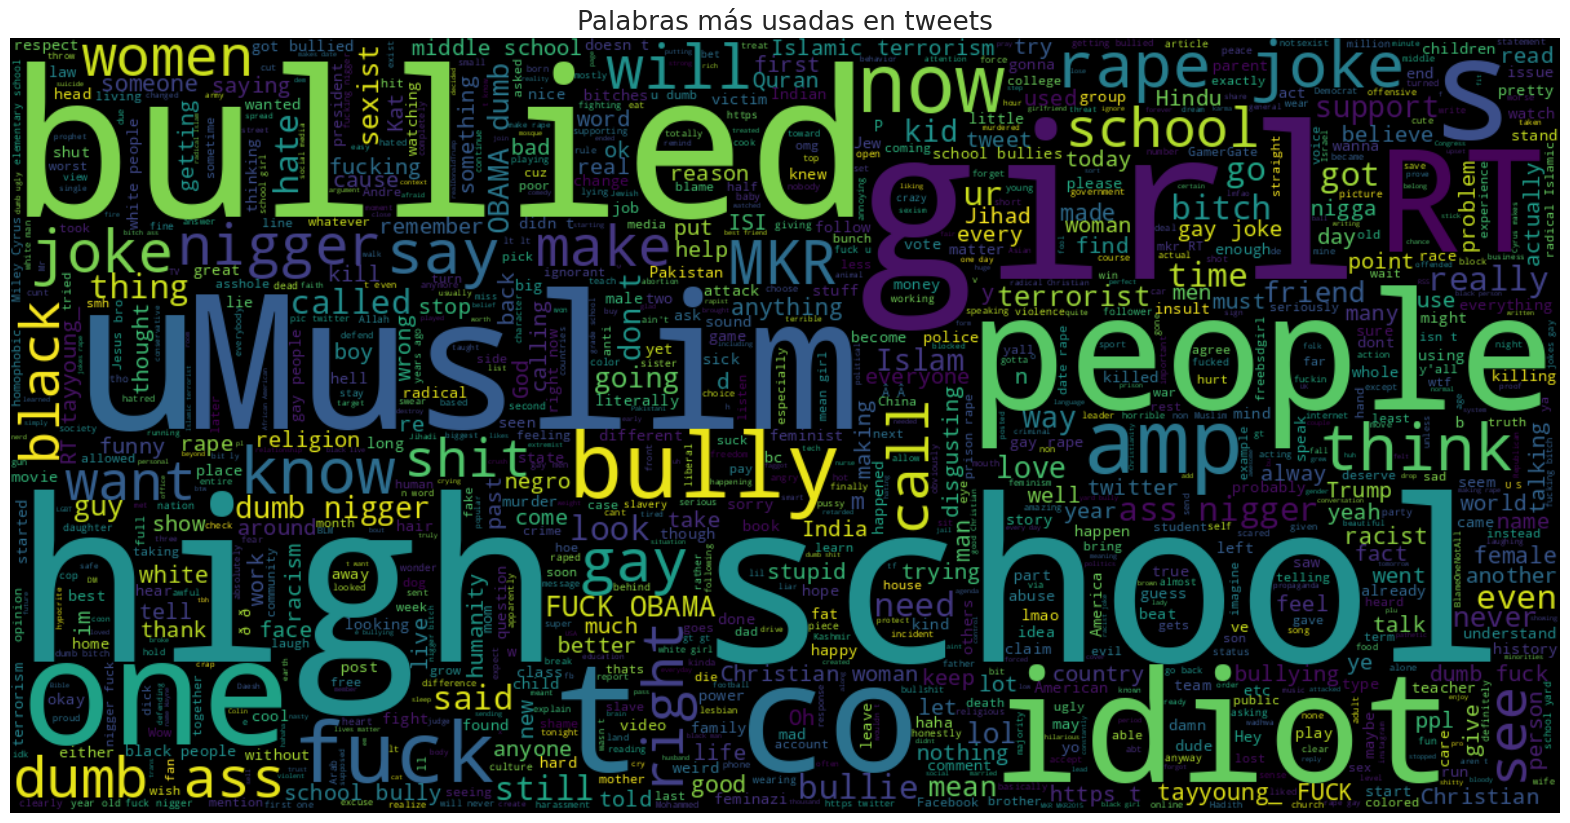

In [ ]:
text = ' '.join([word for word in df['tweet_text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=1000, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Palabras más usadas en tweets', fontsize=19)
plt.show()

# **Partición de los datos**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(  
                                                X_tf,  
                                                df["type_coded"],   
                                                test_size=0.2,  
                                                random_state=42)

# **Módelos de clasificación**

# **1. Logistic Regression**

In [ ]:
# Crear
clf_lr = LogisticRegression(multi_class='multinomial')

In [ ]:
# Entrenar
clf_lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [ ]:
# Predecir
y_pred_lr = clf_lr.predict(X_test)
y_pred_lr

array([1, 2, 1, ..., 0, 1, 4], dtype=int8)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1603
           1       0.97      0.95      0.96      1603
           2       0.90      0.79      0.84      1531
           3       0.52      0.56      0.54      1624
           4       0.56      0.60      0.58      1612
           5       0.94      0.93      0.93      1566

    accuracy                           0.80      9539
   macro avg       0.81      0.80      0.80      9539
weighted avg       0.81      0.80      0.80      9539



<Axes: >

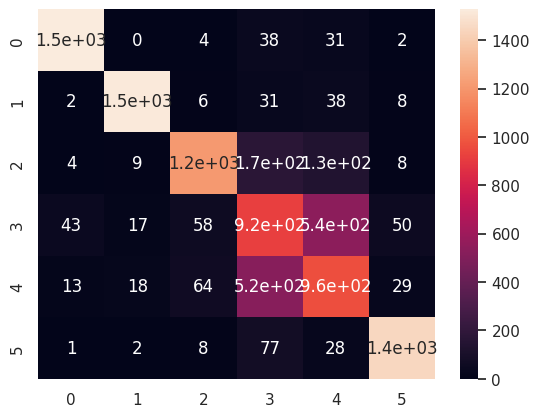

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True)

# **1. Logistic Regression: Tuning**

In [ ]:
parameters = {
    'multi_class' : ['multinomial'],
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [ ]:
log_reg = LogisticRegression()
log_reg_gs = GridSearchCV(log_reg,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
log_reg_gs.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [ ]:
log_reg_gs.best_score_

0.8017456414384511

In [ ]:
log_reg_gs.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# **2. Naive Bayes**

In [ ]:
# Crear
clf_nb = MultinomialNB()

In [ ]:
# Entrenar
clf_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predecir
y_pred_nb = clf_nb.predict(X_test)
y_pred_nb

array([1, 2, 1, ..., 0, 0, 0], dtype=int8)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81      1603
           1       0.83      0.88      0.85      1603
           2       0.75      0.83      0.79      1531
           3       0.66      0.34      0.45      1624
           4       0.60      0.39      0.47      1612
           5       0.77      0.97      0.86      1566

    accuracy                           0.73      9539
   macro avg       0.72      0.73      0.71      9539
weighted avg       0.72      0.73      0.70      9539



<Axes: >

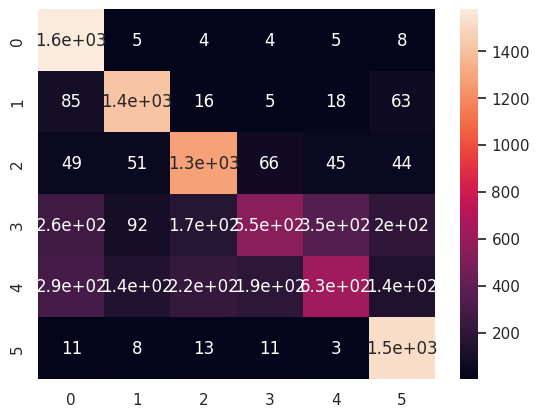

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True)

# **2. Naive Bayes: Tuning**

In [ ]:
parameters = {'alpha': [0.01, 0.001, 0.1, 0.5, 1.0, 10.0],
              'fit_prior': [True, False]
              }

In [ ]:
multi_nb = MultinomialNB()
multi_nb_gs = GridSearchCV(multi_nb,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
multi_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.001, 0.1, 0.5, 1.0, 10.0],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [ ]:
multi_nb_gs.best_score_

0.7442925210255167

In [ ]:
multi_nb_gs.best_estimator_.get_params()

{'alpha': 0.5, 'class_prior': None, 'fit_prior': False, 'force_alpha': 'warn'}

# **3. Random Forest**

In [ ]:
# Crear
clf_rf = RandomForestClassifier()

In [ ]:
# Entrenar
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Predecir
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf

array([1, 2, 1, ..., 0, 1, 4], dtype=int8)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1603
           1       0.98      0.97      0.98      1603
           2       0.88      0.81      0.85      1531
           3       0.53      0.48      0.51      1624
           4       0.53      0.62      0.57      1612
           5       0.95      0.94      0.95      1566

    accuracy                           0.80      9539
   macro avg       0.81      0.80      0.80      9539
weighted avg       0.80      0.80      0.80      9539



<Axes: >

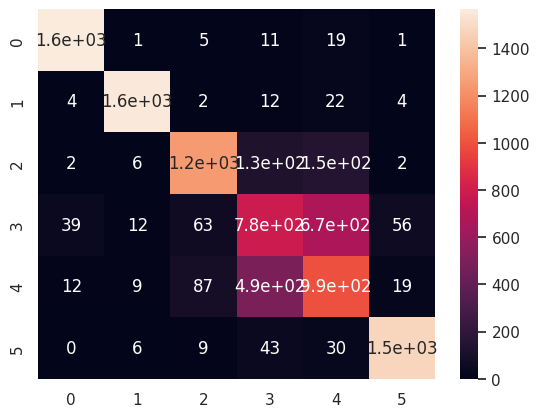

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True)

# **3. Random Forest: Tuning**

In [ ]:
parameters = {
    'n_estimators': [100, 120, 140, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [20, 25, 30],
    'max_leaf_nodes': [20, 25, 30],
}

In [ ]:
random_forest = RandomForestClassifier()
random_forest_gs = GridSearchCV(random_forest,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
random_forest_gs.fit(X_train, y_train)

In [ ]:
random_forest_gs.best_score_

In [ ]:
random_forest_gs.best_estimator_.get_params()

# **4. KNN**

In [ ]:
# Crear
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# Entrenar
clf_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predecir
y_pred_knn = clf_knn.predict(X_test)
y_pred_knn

array(['other_cyberbullying', 'not_cyberbullying', 'other_cyberbullying',
       ..., 'other_cyberbullying', 'other_cyberbullying',
       'other_cyberbullying'], dtype=object)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_knn))

                     precision    recall  f1-score   support

                age       0.97      0.07      0.13      1603
          ethnicity       0.99      0.21      0.35      1603
             gender       0.90      0.11      0.20      1531
  not_cyberbullying       0.23      0.13      0.16      1624
other_cyberbullying       0.16      0.79      0.27      1612
           religion       0.97      0.02      0.05      1566

           accuracy                           0.23      9539
          macro avg       0.70      0.22      0.19      9539
       weighted avg       0.70      0.23      0.19      9539



# **4. KNN: Tuning**

In [ ]:
leaf_size = list(range(1,15))
n_neighbors = list(range(1,15))
p=[1,2]
parameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [ ]:
knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
knn_gs.fit(X_train, y_train)

In [ ]:
knn_gs.best_score_

In [ ]:
knn_gs.best_estimator_.get_params()

# **Validación Cruzada cv-7**

In [ ]:
def cross_validation(model, X, y, cv=7):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              }

In [ ]:
models = {
    "Regresion Logistica" : LogisticRegression(multi_class='multinomial'),
    "Naive Bayes" : MultinomialNB(),
    "Random Forest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
for i in models.keys():
  print('---------- ' + i + ' ----------')
  cross_v = cross_validation(models[i], X_tf, df['cyberbullying_type'])
  for j in cross_v.keys():
    print(f'{j} : {cross_v[j]}')
  print('--------------------')

---------- Regresion Logistica ----------
Training Accuracy scores : [0.89515143 0.89635265 0.89657281 0.89667066 0.89649943 0.89696421
 0.89769808]
Mean Training Accuracy : 89.65584675031405
Validation Accuracy scores : [0.80275903 0.80023485 0.79524439 0.80463819 0.79994129 0.80874798
 0.79935418]
Mean Validation Accuracy : 80.15599849232447
--------------------
---------- Naive Bayes ----------
Training Accuracy scores : [0.83668477 0.83712909 0.83683554 0.83788742 0.8364686  0.83739818
 0.83583258]
Mean Training Accuracy : 83.68908824466956
Validation Accuracy scores : [0.74024068 0.73800088 0.7344782  0.73095553 0.74137678 0.73726699
 0.73873477]
Mean Validation Accuracy : 73.72934046113325
--------------------
---------- Random Forest ----------
Training Accuracy scores : [0.96641225 0.96678001 0.96636415 0.96731818 0.96594829 0.96670662
 0.96663323]
Mean Training Accuracy : 96.65946763173936
Validation Accuracy scores : [0.80011741 0.80008807 0.80023485 0.80067518 0.79862028 0.7